In [115]:
import torchvision.datasets

In [116]:
from torchvision.datasets import OxfordIIITPet

In [117]:
import torchvision.transforms as T
import torch.nn as nn

In [118]:
import torchvision.transforms.functional as TF,torch.nn.functional as F

In [119]:
import fastcore.all as fc

In [120]:
from torchvision import transforms

In [121]:
custom_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to a common size
    transforms.ToTensor(),           # Convert images to Torch tensors
    #transforms.Lambda(lambda x: x / 256.0),  # Normalize pixel values by dividing by 256
])

In [122]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

class CustomOxfordIIITPet(OxfordIIITPet):
    def __init__(self, root, split, target_types, custom_transform=None, **kwargs):
        super(CustomOxfordIIITPet, self).__init__(root=root, split=split, target_types=target_types, **kwargs)
        self.custom_transform = custom_transform

    def __getitem__(self, index):
        img, target = super(CustomOxfordIIITPet, self).__getitem__(index)

        if self.custom_transform is not None:
            img = self.custom_transform(img)
            target = self.custom_transform(target)

        return img, target

# Define your custom transformation
custom_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to a common size
    transforms.ToTensor(),           # Convert images to Torch tensors
    #transforms.Lambda(lambda x: x / 256.0),  # Normalize pixel values by dividing by 256
])

# Create the dataset and include the custom transform within it
train_ds = CustomOxfordIIITPet(
    root='./',
    split='trainval',
    target_types='segmentation',
    custom_transform=custom_transform,
    download=True
)

test_ds = CustomOxfordIIITPet(
    root='./',
    split='test',
    target_types='segmentation',
    custom_transform=custom_transform,
    download=True
)

# Access an item from the dataset using indexing
sample_image, sample_target = train_ds[4]

In [123]:
sample_image.shape,sample_target.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

In [124]:
total_ds = train_ds+test_ds

In [125]:
from torch.utils.data import DataLoader, random_split

In [126]:
len(total_ds)

7349

In [127]:
total_data = len(total_ds)
train_size = int(0.8 * total_data)
val_size = total_data - train_size
print(train_size,val_size)

# Use random_split to split the dataset into training and validation
train_ds, val_ds = random_split(total_ds, [train_size, val_size])

5879 1470


In [128]:
len(train_ds),len(val_ds)

(5879, 1470)

In [129]:
from learner import *
from datasets import *
from conv import *
from training import get_dls

In [133]:
dls = DataLoaders(*get_dls(train_ds, val_ds, bs=256, num_workers=8))

In [131]:
xb,yb = next(iter(dls.train))

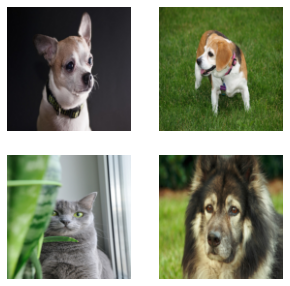

In [132]:
show_images(xb[:4], imsize=2.5)

In [134]:
from functools import partial

In [ ]:
def up_block(ni, nf, ks=3, act=act_gr):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act))

In [135]:
import torch.nn as nn

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels,max_pooling=True):
        super(ContractingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool = fc.noop if (not max_pooling) else nn.AvgPool2d(2, ceil_mode=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        skip = x  # store the output for the skip connection
        x = self.pool(x)
        
        return x, skip

class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        
    def forward(self, x,skip=None):
        
        x = self.upsample(x)
        x = torch.cat((x, skip), dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        
        
        return x
    
class UNet(nn.Module):
    def __init__(self,in_channels=3, n_filters=32, n_classes=3):
        super(UNet, self).__init__()
        
        self.contract1 = ContractingBlock(in_channels, n_filters,max_pooling=True) 
        self.contract2 = ContractingBlock(n_filters, n_filters*2,max_pooling=True)
        self.contract3 = ContractingBlock( n_filters*2,  n_filters*4,max_pooling=True)
        self.contract4 = ContractingBlock( n_filters*4,  n_filters*8,max_pooling=True)
        self.contract5 = ContractingBlock( n_filters*8,  n_filters*16,max_pooling=False)
        
        self.expand1 = ExpandingBlock(n_filters*16, n_filters*8)
        self.expand2 = ExpandingBlock(n_filters*8, n_filters*4)
        self.expand3 = ExpandingBlock(n_filters*4, n_filters*2)
        self.expand4 = ExpandingBlock(n_filters*2, n_filters)
        
        self.pen_conv = conv(n_filters, n_classes, stride=1, act=True, ks=3)
        
        self.final_conv = conv(n_classes,1, stride=1, act=False, ks=1)
        
    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        x, skip2 = self.contract2(x)
        x, skip3 = self.contract3(x)
        x, skip4 = self.contract4(x)
        x, _ = self.contract5(x)
        
        # Expanding path
        x = self.expand1(x, skip4)
        x = self.expand2(x, skip3)
        x = self.expand3(x, skip2)
        x = self.expand4(x, skip1)
        
        x =  self.pen_conv(x)
        return self.final_conv(x)
        
         
        

    
    
        
        

In [136]:
model = UNet()

In [137]:
import torch

In [138]:
x = torch.randn(512,3,128,128)


In [ ]:
y = model(x)

In [67]:
y.shape

torch.Size([512, 1, 128, 128])

In [68]:
import torch
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10

    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)

    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [71]:
from torch import optim
from functools import partial

In [72]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

In [73]:
import sys,gc,traceback
import fastcore.all as fc

In [74]:
# %% ../nbs/11_initializing.ipynb 11
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

# %% ../nbs/11_initializing.ipynb 12
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

# %% ../nbs/11_initializing.ipynb 13
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [80]:
clean_mem()

In [75]:
from torch.optim import lr_scheduler

In [76]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [77]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [81]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.binary_cross_entropy_with_logits, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.869,0,train
0.844,0,eval
0.862,1,train
0.843,1,eval
0.845,2,train
0.832,2,eval
0.818,3,train
0.801,3,eval
0.785,4,train
0.764,4,eval


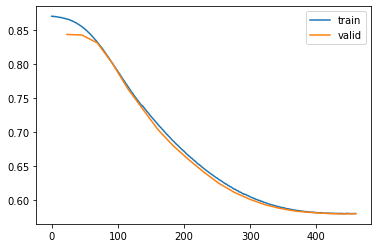

In [82]:
learn.fit(epochs)

In [86]:
len(val_ds)

1470

In [99]:
device = 'cuda'
import matplotlib as plt
import matplotlib.pyplot as plt

In [112]:
# Results of Validation Dataset
def VisualizeResults(index):
    img,actual_mask = val_ds[index]
    img = img.unsqueeze(0)
    pred_y = model(img.to(device))
    #pred_mask = tf.argmax(pred_y[0], axis=-1)
    #pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    show_image(img.squeeze(),ax = arr[0])
    arr[0].set_title('Processed Image')
    show_image(actual_mask,arr[1])
    arr[1].set_title('Actual Masked Image ')
    show_image(pred_y.squeeze(),arr[2])
    arr[2].set_title('Predicted Masked Image ')

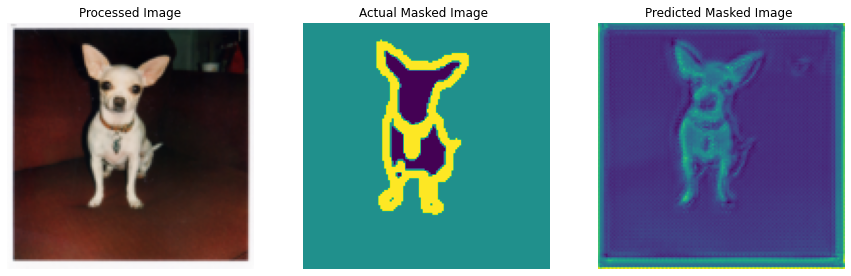

In [113]:
# Add any index to contrast the predicted mask with actual mask
index = 700
VisualizeResults(index)